In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
from os.path import join
import json
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.network_edm_lib import SongUNet, DhariwalUNet
from core.DiT_model_lib import *
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid
from pprint import pprint

saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

In [4]:
def find_largest_ckpt_step(ckptdir, verbose=True):
    ckpt_files = [f for f in os.listdir(ckptdir) if f.startswith("model_epoch_") and f.endswith(".pth")]
    ckpt_steps = [int(f.split("_")[-1].split(".")[0]) for f in ckpt_files]
    if len(ckpt_steps) == 0:
        if verbose:
            print("No checkpoints found in the directory! check the path: ", ckptdir)
        return None
    else:
        if verbose:
            print(f"Found {len(ckpt_steps)} checkpoints in the directory, largest step is {max(ckpt_steps)}")
        return max(ckpt_steps)


def find_all_ckpt_steps(ckptdir, verbose=True):
    ckpt_files = [f for f in os.listdir(ckptdir) if f.startswith("model_epoch_") and f.endswith(".pth")]
    ckpt_steps = [int(f.split("_")[-1].split(".")[0]) for f in ckpt_files]
    if verbose:
        print(f"Found {len(ckpt_steps)} checkpoints in the directory, largest step is {max(ckpt_steps)}")
    return sorted(ckpt_steps)


# Refactored functions for visualizing gradient maps
from mpl_toolkits.axes_grid1 import ImageGrid
def compute_gradient_map(model, x_shape, sigma_val, output_coords, device, x_probe=None, target="denoiser"):
    """
    Compute gradient map for a specific sigma value and output coordinates.
    
    Args:
        model: The denoiser model
        x_shape: Shape of the input tensor (e.g., (3, 32, 32))
        sigma_val: Sigma value for the denoiser
        output_coords: Tuple of (channel, y, x) coordinates for the output pixel
        device: Device to run computation on
    
    Returns:
        Gradient map tensor
    """
    # Set up the output map (focusing on the specified pixel)
    output_map = torch.zeros(x_shape).to(device)
    if output_coords is None:
        # Default to center pixel if not specified
        c, h, w = x_shape
        output_map[:, h//2, w//2] = 1
    else:
        c, y, x = output_coords
        if c is None:  # If channel is None, set all channels
            output_map[:, y, x] = 1
        else:
            output_map[c, y, x] = 1
    
    # Set up the probe point
    if x_probe is None:
        x_probe = sigma_val * torch.randn(x_shape).to(device)
    else:
        x_probe = x_probe.detach().clone().to(device)
    x_probe.requires_grad_(True)
    
    # Compute the denoiser output
    t_sigma = sigma_val * torch.ones(1, device=device)
    denoised = model(x_probe.view(1, *x_shape), t_sigma)
    if target == "denoiser":
        scalar = (output_map * denoised).sum()
    elif target == "score":
        score = (denoised - x_probe.view(1, *x_shape)) / t_sigma[:, None]
        scalar = (output_map * score[0]).sum()
    else:
        raise ValueError(f"Invalid target: {target}")
    
    # Compute scalar output and get gradient
    scalar.backward()
    # Return the gradient
    return x_probe.grad.detach().cpu()



def visualize_gradient_maps(model, x_shape, sigma_values, output_coords=None, target="denoiser",
                           device='cuda', reduction='abs_mean', figsize=(14, 14)):
    """
    Visualize gradient maps for different sigma values.
    
    Args:
        model: The denoiser model
        x_shape: Shape of the input tensor (e.g., (3, 32, 32))
        sigma_values: List of sigma values to test
        output_coords: Tuple of (channel, y, x) coordinates for the output pixel
                      If None, defaults to center pixel
        device: Device to run computation on
        reduction: How to reduce channel dimension ('abs_mean', 'mean', 'max', or None)
        figsize: Figure size for the plot
    
    Returns:
        List of computed gradient maps
    """
    gradient_maps = []
    
    # Compute gradient maps for each sigma
    for sigma_val in sigma_values:
        print(f"Computing gradient map for sigma = {sigma_val}")
        gradient_map = compute_gradient_map(model, x_shape, sigma_val, output_coords, device, target=target)
        
        # Apply reduction if specified
        if reduction == 'abs_mean':
            gradient_map = gradient_map.abs().mean(0)
        elif reduction == 'mean':
            gradient_map = gradient_map.mean(0)
        elif reduction == 'max':
            gradient_map = gradient_map.abs().max(0)[0]
        # If None, keep all channels
        
        gradient_maps.append(gradient_map)
        # Clear gradients for next iteration
        torch.cuda.empty_cache()
    
    # Create a montage of the gradient maps
    rows = int(len(sigma_values)**0.5)
    cols = (len(sigma_values) + rows - 1) // rows  # Ceiling division
    
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(rows, cols),
                    axes_pad=0.3,
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.1)
    
    # Add each gradient map to the grid
    for i, (gradient_map, sigma_val) in enumerate(zip(gradient_maps, sigma_values)):
        if i < len(grid):  # Ensure we don't go out of bounds
            ax = grid[i]
            
            # Handle multi-channel gradient maps
            if len(gradient_map.shape) == 3 and reduction is None:
                # Just show first channel if no reduction
                im = ax.imshow(gradient_map[0], cmap="viridis")
            else:
                im = ax.imshow(gradient_map, cmap="viridis")
                
            ax.set_title(f"σ = {sigma_val}")
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Add colorbar
    grid.cbar_axes[0].colorbar(im)
    
    # Add title with output coordinates
    if output_coords:
        c, y, x = output_coords
        channel_str = f"channel {c}" if c is not None else "all channels"
        plt.suptitle(f"Gradient Maps of {target} for Different Sigma Values (Output at {channel_str}, y={y}, x={x})")
    else:
        plt.suptitle(f"Gradient Maps of {target} for Different Sigma Values (Output at center pixel)")
    
    plt.tight_layout()
    plt.show()
    
    return fig, gradient_maps


def compute_jacobian(model, x_probe, sigma, device="cuda", target="denoiser", pbar=True):
    x_shape = x_probe.shape
    jacobian = torch.zeros(np.prod(x_shape[:]), np.prod(x_shape[:])).to(device)
    if pbar:
        pbar = trange(np.prod(x_shape[:]))
    else:
        pbar = range(np.prod(x_shape[:]))
    for idx in pbar:
        coords = np.unravel_index(idx, x_shape[:])
        grad = compute_gradient_map(model, x_shape, sigma, coords, device, x_probe=x_probe, target=target)
        jacobian[idx, :] = grad.view(-1)
    return jacobian


# %%
# %% [markdown]
# ### Loading CNN
#%%
def create_unet_model(config):
    unet = SongUNet(in_channels=config.channels, 
                out_channels=config.channels, 
                num_blocks=config.layers_per_block, 
                attn_resolutions=config.attn_resolutions, 
                decoder_init_attn=config.decoder_init_attn if 'decoder_init_attn' in config else True,
                model_channels=config.model_channels, 
                channel_mult=config.channel_mult, 
                dropout=config.dropout, 
                img_resolution=config.img_size, 
                label_dim=config.label_dim,
                embedding_type='positional', 
                encoder_type='standard', 
                decoder_type='standard', 
                augment_dim=config.augment_dim, #  no augmentation , 9 for defaults. 
                channel_mult_noise=1, 
                resample_filter=[1,1], 
                )
    pytorch_total_grad_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f'total number of trainable parameters in the Score Model: {pytorch_total_grad_params}')
    pytorch_total_params = sum(p.numel() for p in unet.parameters())
    print(f'total number of parameters in the Score Model: {pytorch_total_params}')
    return unet

device = "cuda" if torch.cuda.is_available() else "cpu"



In [ ]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST* -d

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_MLP_EDM
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_MLP_EDM_width1024_small_lr_long_train
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_1block_noattn
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_1block_wide128_noattn
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_2blocks_noattn
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Proje

### UNet 

In [40]:
import PIL


In [ ]:
# loading config 
expname = "MNIST_UNet_CNN_EDM_4blocks_noattn"
expname = "MNIST_UNet_CNN_EDM_4blocks_wide64_noattn"
expname = "MNIST_UNet_CNN_EDM_shallow"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
config = edict(json.load(open(f"{savedir}/config.json")))
# args = edict(json.load(open(f"{savedir}/args.json")))
pprint(config)
unet = create_unet_model(config)
# ckpt_step_list = find_all_ckpt_steps(ckptdir)
# ckpt_step = max(ckpt_step_list[-1:])
# ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
ckpt_path = join(savedir, f"model_final.pth")
unet.load_state_dict(torch.load(ckpt_path))
print("load ckpt from ", ckpt_path)
CNN_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
CNN_precd.eval().to(device)
CNN_precd.requires_grad_(False);
# figdir = join(savedir, "gradient_maps")
# jacobdir = join(savedir, "jacobian_store")
# os.makedirs(figdir, exist_ok=True)
# os.makedirs(jacobdir, exist_ok=True)

{'attn_resolutions': [0],
 'augment_dim': 0,
 'channel_mult': [1, 2],
 'channels': 1,
 'dropout': 0.0,
 'img_size': 32,
 'label_dim': 0,
 'layers_per_block': 2,
 'model_channels': 32}
total number of trainable parameters in the Score Model: 982049
total number of parameters in the Score Model: 982049
load ckpt from  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_shallow/model_final.pth


/tmp/ipykernel_1275571/516785737.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(ckpt_path))


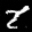

In [41]:
seed = 1234
noise_init = torch.randn(1, 1, 32, 32, generator=torch.Generator(device=device).manual_seed(seed), device=device)
x_out_i = edm_sampler(CNN_precd, noise_init, num_steps=25, 
            sigma_min=0.002, sigma_max=12.5, rho=7, return_traj=False)
to_imgrid(((x_out_i.cpu()+1)/2).clamp(0, 1), padding=1)#.resize((64, 64), resample=PIL.Image.Resampling.NEAREST)

{'attn_resolutions': [],
 'augment_dim': 0,
 'channel_mult': [1, 2, 3, 4],
 'channels': 1,
 'decoder_init_attn': True,
 'dropout': 0.0,
 'img_size': 32,
 'label_dim': 0,
 'layers_per_block': 1,
 'model_channels': 64}
total number of trainable parameters in the Score Model: 15916417
total number of parameters in the Score Model: 15916417
load ckpt from  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_wide64_noattn/model_final.pth


/tmp/ipykernel_1275571/4197375733.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(ckpt_path))


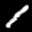

In [42]:
# loading config 
expname = "MNIST_UNet_CNN_EDM_4blocks_noattn"
expname = "MNIST_UNet_CNN_EDM_4blocks_wide64_noattn"
# expname = "MNIST_UNet_CNN_EDM_shallow"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
config = edict(json.load(open(f"{savedir}/config.json")))
# args = edict(json.load(open(f"{savedir}/args.json")))
pprint(config)
unet = create_unet_model(config)
# ckpt_step_list = find_all_ckpt_steps(ckptdir)
# ckpt_step = max(ckpt_step_list[-1:])
# ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
ckpt_path = join(savedir, f"model_final.pth")
unet.load_state_dict(torch.load(ckpt_path))
print("load ckpt from ", ckpt_path)
CNN_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
CNN_precd.eval().to(device)
CNN_precd.requires_grad_(False);
# figdir = join(savedir, "gradient_maps")
# jacobdir = join(savedir, "jacobian_store")
# os.makedirs(figdir, exist_ok=True)
# os.makedirs(jacobdir, exist_ok=True)
seed = 1234
noise_init = torch.randn(1, 1, 32, 32, generator=torch.Generator(device=device).manual_seed(seed), device=device)
x_out_i = edm_sampler(CNN_precd, noise_init, num_steps=25, 
            sigma_min=0.002, sigma_max=12.5, rho=7, return_traj=False)
to_imgrid(((x_out_i.cpu()+1)/2).clamp(0, 1), padding=1)#.resize((64, 64), resample=PIL.Image.Resampling.NEAREST)

{'attn_resolutions': [],
 'augment_dim': 0,
 'channel_mult': [1, 2, 3, 4],
 'channels': 1,
 'decoder_init_attn': True,
 'dropout': 0.0,
 'img_size': 32,
 'label_dim': 0,
 'layers_per_block': 1,
 'model_channels': 16}
total number of trainable parameters in the Score Model: 1000801
total number of parameters in the Score Model: 1000801
load ckpt from  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn_smalllr_longtrain/model_final.pth


/tmp/ipykernel_1275571/3819551461.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(ckpt_path))


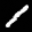

In [43]:
# loading config 
expname = "MNIST_UNet_CNN_EDM_4blocks_noattn"
expname = "MNIST_UNet_CNN_EDM_4blocks_noattn_smalllr_longtrain"
# expname = "MNIST_UNet_CNN_EDM_shallow"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
config = edict(json.load(open(f"{savedir}/config.json")))
# args = edict(json.load(open(f"{savedir}/args.json")))
pprint(config)
unet = create_unet_model(config)
# ckpt_step_list = find_all_ckpt_steps(ckptdir)
# ckpt_step = max(ckpt_step_list[-1:])
# ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
ckpt_path = join(savedir, f"model_final.pth")
unet.load_state_dict(torch.load(ckpt_path))
print("load ckpt from ", ckpt_path)
CNN_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
CNN_precd.eval().to(device)
CNN_precd.requires_grad_(False);
# figdir = join(savedir, "gradient_maps")
# jacobdir = join(savedir, "jacobian_store")
# os.makedirs(figdir, exist_ok=True)
# os.makedirs(jacobdir, exist_ok=True)
seed = 1234
noise_init = torch.randn(1, 1, 32, 32, generator=torch.Generator(device=device).manual_seed(seed), device=device)
x_out_i = edm_sampler(CNN_precd, noise_init, num_steps=25, 
            sigma_min=0.002, sigma_max=12.5, rho=7, return_traj=False)
to_imgrid(((x_out_i.cpu()+1)/2).clamp(0, 1), padding=1)#.resize((64, 64), resample=PIL.Image.Resampling.NEAREST)

In [ ]:
data_Xtsr = torch.load("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/wordnet_render_dataset/ffhq-32x32.pt")
ref_x_raw = data_Xtsr[77]
ref_x = (ref_x_raw - 0.5) / 0.5
# ref_x = ref_x.flatten()
plt.imshow(ref_x_raw.permute(1, 2, 0).cpu().numpy())

In [ ]:
imgshape = (3, 32, 32)
figdir = join(savedir, "gradient_maps")
os.makedirs(figdir, exist_ok=True)
ckpt_step_list = find_all_ckpt_steps(ckptdir)
for ckpt_step in ckpt_step_list:
    ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
    CNN_precd.load_state_dict(torch.load(ckpt_path))
    device = "cuda"
    CNN_precd = CNN_precd.to(device).eval()
    CNN_precd.requires_grad_(False);
    save_dict = {}
    noise_z = torch.randn(imgshape, generator=torch.Generator().manual_seed(0))
    for sigma in tqdm([0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]):
        x_probe = ref_x + sigma * noise_z
        jacobian = compute_jacobian(CNN_precd, x_probe, sigma, device, pbar=False)
        save_dict[(sigma, "jacobian")] = jacobian.cpu()
        save_dict[(sigma, "x_probe")] = x_probe
    torch.save(save_dict, join(jacobdir, f"jacobian_ref_img_w_noise_step{ckpt_step:06d}.pth"))